<a href="https://colab.research.google.com/github/sargyri/Drop_Lev/blob/master/Machine_learning/contour_check.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2018 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [ ]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# Lev Droplet 

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/keras/basic_regression"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/r2.0rc/site/en/tutorials/keras/basic_regression.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/r2.0rc/site/en/tutorials/keras/basic_regression.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

Determination of ST by NN using coords (rho,theta, volume, volt)

In [ ]:
# Use seaborn for pairplot
#!pip install seaborn
#!pip install talos
#!pip install -q  --no-deps tensorflow-addons~=0.7

In [1]:
!pip install lmfit

     |████████████████████████████████| 266kB 1.7MB/s 
     |████████████████████████████████| 215kB 4.8MB/s 
     |████████████████████████████████| 256kB 7.4MB/s 
  Created wheel for lmfit: filename=lmfit-1.0.1-cp36-none-any.whl size=81991 sha256=4ce17f84e5c41638c6633426f23cc1eba4114652c3e741f15c077843cfdd2b60
  Stored in directory: /root/.cache/pip/wheels/ef/22/8d/6cd9c0af36f501cfb248673b05dad5d2c27504951d55519acb
  Created wheel for asteval: filename=asteval-0.9.19-cp36-none-any.whl size=17486 sha256=d8027df3e217a0716a2aa03b6400538a7eb8222f49e9a2fd30e1edbd8b22d02a
  Stored in directory: /root/.cache/pip/wheels/59/da/bf/62853db4291f1c5f91326e32e4d1766b8cfcccd1c0e6eaf53f
Successfully built lmfit asteval


In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib
import pprint
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import seaborn as sns

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.callbacks import ModelCheckpoint

import tensorflow_addons as tfa

print(tf.__version__)


Instructions for updating:
non-resource variables are not supported in the long term
2.3.0


In [3]:
def pol2cart(rho, phi):
    """
    Converts polar coordinates to cartesian

    Input parameters
    ----------
    rho, phi: Polar coordinates (phi in rad)
    
    Returns
    -------
    x, y: Cartesian coordinates

    """
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)

Run the next code box only if google drive is not mounted to colab

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


If it **is** mounted continue from here on

Check the connection to google's **GPU**

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

**Or** check the connection to google's **TPU**

In [ ]:
if 'COLAB_TPU_ADDR' not in os.environ:
  print('ERROR: Not connected to a TPU runtime; please see the first cell in this notebook for instructions!')
else:
  tpu_address = 'grpc://' + os.environ['COLAB_TPU_ADDR']
  print ('TPU address is', tpu_address)

  with tf.Session(tpu_address) as session:
    devices = session.list_devices()
    
  print('TPU devices:')
  pprint.pprint(devices)

### Get the data
First download the dataset!

**Option 1**: Upload files

In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
import io
csvfilename=str('TritonX100_conci_0.0100_all.csv')
input = pd.read_csv(io.BytesIO(uploaded[csvfilename]))
#input = pd.read_csv(csvfilename, sep="\t")
# Dataset is now stored in a Pandas Dataframe
input.shape

**Option 2**: Import files from drive

In [6]:
#From the drive folder that is mounted to collab go to the file that you are interested in, 
#right click and copy the path of the file. Paste it in csvfilename:

fileSDS1=pd.read_csv(str('/content/drive/My Drive/DropLev/Levitator_2/Training/SDS/SDS_conci_0.01054_all.csv'), sep="\t")
fileSDS2=pd.read_csv(str('/content/drive/My Drive/DropLev/Levitator_2/Training/SDS/SDS_conci_0.02108_all.csv'), sep='\t')
fileSDS3=pd.read_csv(str('/content/drive/My Drive/DropLev/Levitator_2/Training/SDS/SDS_conci_0.04273_all.csv'), sep='\t')
fileSDS4=pd.read_csv(str('/content/drive/My Drive/DropLev/Levitator_2/Training/SDS/SDS_conci_0.08828_all.csv'), sep="\t")
fileSDS5=pd.read_csv(str('/content/drive/My Drive/DropLev/Levitator_2/Training/SDS/SDS_conci_0.25000_all.csv'), sep="\t")
fileSDS6=pd.read_csv(str('/content/drive/My Drive/DropLev/Levitator_2/Training/SDS/SDS_conci_0.50000_all.csv'), sep="\t")
fileSDS7=pd.read_csv(str('/content/drive/My Drive/DropLev/Levitator_2/Training/SDS/SDS_conci_0.75000_all.csv'), sep="\t")
fileSDS8=pd.read_csv(str('/content/drive/My Drive/DropLev/Levitator_2/Training/SDS/SDS_conci_1.00000_all.csv'), sep="\t")
fileSDS9=pd.read_csv(str('/content/drive/My Drive/DropLev/Levitator_2/Training/SDS/SDS_conci_1.25000_all.csv'), sep="\t")
fileSDS10=pd.read_csv(str('/content/drive/My Drive/DropLev/Levitator_2/Training/SDS/SDS_conci_1.50000_all.csv'), sep="\t")
fileSDS11=pd.read_csv(str('/content/drive/My Drive/DropLev/Levitator_2/Training/SDS/SDS_conci_2.00000_all.csv'), sep="\t")
fileSDS12=pd.read_csv(str('/content/drive/My Drive/DropLev/Levitator_2/Training/SDS/SDS_conci_2.50000_all.csv'), sep="\t")
fileSDS13=pd.read_csv(str('/content/drive/My Drive/DropLev/Levitator_2/Training/SDS/SDS_conci_3.00000_all.csv'), sep="\t")
fileSDS14=pd.read_csv(str('/content/drive/My Drive/DropLev/Levitator_2/Training/SDS/SDS_conci_3.50000_all.csv'), sep="\t")
fileSDS15=pd.read_csv(str('/content/drive/My Drive/DropLev/Levitator_2/Training/SDS/SDS_conci_4.00000_all.csv'), sep="\t")
fileSDS16=pd.read_csv(str('/content/drive/My Drive/DropLev/Levitator_2/Training/SDS/SDS_conci_4.50000_all.csv'), sep="\t")
fileSDS17=pd.read_csv(str('/content/drive/My Drive/DropLev/Levitator_2/Training/SDS/SDS_conci_5.50000_all.csv'), sep="\t")
fileSDS18=pd.read_csv(str('/content/drive/My Drive/DropLev/Levitator_2/Training/SDS/SDS_conci_6.50000_all.csv'), sep="\t")
fileSDS19=pd.read_csv(str('/content/drive/My Drive/DropLev/Levitator_2/Training/SDS/SDS_conci_7.50000_all.csv'), sep="\t")
fileSDS20=pd.read_csv(str('/content/drive/My Drive/DropLev/Levitator_2/Training/SDS/SDS_conci_8.50000_all.csv'), sep="\t")
fileSDS21=pd.read_csv(str('/content/drive/My Drive/DropLev/Levitator_2/Training/SDS/SDS_conci_24.75900_all.csv'), sep="\t")

fileTrit1=pd.read_csv(str('/content/drive/My Drive/DropLev/Levitator_2/Training/TritonX100/TritonX_conci_0.00250_all.csv'), sep="\t")
fileTrit2=pd.read_csv(str('/content/drive/My Drive/DropLev/Levitator_2/Training/TritonX100/TritonX_conci_0.00500_all.csv'), sep="\t")
fileTrit3=pd.read_csv(str('/content/drive/My Drive/DropLev/Levitator_2/Training/TritonX100/TritonX_conci_0.00750_all.csv'), sep="\t")
fileTrit4=pd.read_csv(str('/content/drive/My Drive/DropLev/Levitator_2/Training/TritonX100/TritonX_conci_0.01000_all.csv'), sep="\t")
fileTrit5=pd.read_csv(str('/content/drive/My Drive/DropLev/Levitator_2/Training/TritonX100/TritonX_conci_0.01500_all.csv'), sep="\t")
fileTrit6=pd.read_csv(str('/content/drive/My Drive/DropLev/Levitator_2/Training/TritonX100/TritonX_conci_0.02000_all.csv'), sep="\t")
fileTrit7=pd.read_csv(str('/content/drive/My Drive/DropLev/Levitator_2/Training/TritonX100/TritonX_conci_0.02500_all.csv'), sep="\t")
fileTrit8=pd.read_csv(str('/content/drive/My Drive/DropLev/Levitator_2/Training/TritonX100/TritonX_conci_0.03500_all.csv'), sep="\t")
fileTrit9=pd.read_csv(str('/content/drive/My Drive/DropLev/Levitator_2/Training/TritonX100/TritonX_conci_0.05000_all.csv'), sep="\t")
fileTrit10=pd.read_csv(str('/content/drive/My Drive/DropLev/Levitator_2/Training/TritonX100/TritonX_conci_0.07500_all.csv'), sep="\t")
fileTrit11=pd.read_csv(str('/content/drive/My Drive/DropLev/Levitator_2/Training/TritonX100/TritonX_conci_0.10000_all.csv'), sep="\t")
fileTrit12=pd.read_csv(str('/content/drive/My Drive/DropLev/Levitator_2/Training/TritonX100/TritonX_conci_0.12500_all.csv'), sep="\t")
fileTrit13=pd.read_csv(str('/content/drive/My Drive/DropLev/Levitator_2/Training/TritonX100/TritonX_conci_0.15000_all.csv'), sep="\t")
fileTrit14=pd.read_csv(str('/content/drive/My Drive/DropLev/Levitator_2/Training/TritonX100/TritonX_conci_0.17500_all.csv'), sep="\t")
fileTrit15=pd.read_csv(str('/content/drive/My Drive/DropLev/Levitator_2/Training/TritonX100/TritonX_conci_0.20000_all.csv'), sep="\t")
fileTrit16=pd.read_csv(str('/content/drive/My Drive/DropLev/Levitator_2/Training/TritonX100/TritonX_conci_0.25000_all.csv'), sep="\t")
fileTrit17=pd.read_csv(str('/content/drive/My Drive/DropLev/Levitator_2/Training/TritonX100/TritonX_conci_0.30000_all.csv'), sep="\t")
fileTrit18=pd.read_csv(str('/content/drive/My Drive/DropLev/Levitator_2/Training/TritonX100/TritonX_conci_0.45000_all.csv'), sep="\t")
fileTrit19=pd.read_csv(str('/content/drive/My Drive/DropLev/Levitator_2/Training/TritonX100/TritonX_conci_1.00000_all.csv'), sep="\t")
fileTrit20=pd.read_csv(str('/content/drive/My Drive/DropLev/Levitator_2/Training/TritonX100/TritonX_conci_3.00000_all.csv'), sep="\t")
fileTrit21=pd.read_csv(str('/content/drive/My Drive/DropLev/Levitator_2/Training/TritonX100/TritonX_conci_10.00000_all.csv'), sep="\t")

fileCTAB1=pd.read_csv(str('/content/drive/My Drive/DropLev/Levitator_2/Training/CTAB/CTAB_conci_0.00100_all.csv'), sep="\t")
fileCTAB2=pd.read_csv(str('/content/drive/My Drive/DropLev/Levitator_2/Training/CTAB/CTAB_conci_0.00200_all.csv'), sep="\t")
fileCTAB3=pd.read_csv(str('/content/drive/My Drive/DropLev/Levitator_2/Training/CTAB/CTAB_conci_0.00500_all.csv'), sep="\t")
fileCTAB4=pd.read_csv(str('/content/drive/My Drive/DropLev/Levitator_2/Training/CTAB/CTAB_conci_0.01000_all.csv'), sep="\t")
fileCTAB5=pd.read_csv(str('/content/drive/My Drive/DropLev/Levitator_2/Training/CTAB/CTAB_conci_0.01500_all.csv'), sep="\t")
fileCTAB6=pd.read_csv(str('/content/drive/My Drive/DropLev/Levitator_2/Training/CTAB/CTAB_conci_0.05500_all.csv'), sep="\t")
fileCTAB7=pd.read_csv(str('/content/drive/My Drive/DropLev/Levitator_2/Training/CTAB/CTAB_conci_0.10000_all.csv'), sep="\t")
fileCTAB8=pd.read_csv(str('/content/drive/My Drive/DropLev/Levitator_2/Training/CTAB/CTAB_conci_0.15000_all.csv'), sep="\t")
fileCTAB9=pd.read_csv(str('/content/drive/My Drive/DropLev/Levitator_2/Training/CTAB/CTAB_conci_0.20000_all.csv'), sep="\t")
fileCTAB10=pd.read_csv(str('/content/drive/My Drive/DropLev/Levitator_2/Training/CTAB/CTAB_conci_0.25000_all.csv'), sep="\t")
fileCTAB11=pd.read_csv(str('/content/drive/My Drive/DropLev/Levitator_2/Training/CTAB/CTAB_conci_0.30000_all.csv'), sep="\t")
fileCTAB12=pd.read_csv(str('/content/drive/My Drive/DropLev/Levitator_2/Training/CTAB/CTAB_conci_0.40000_all.csv'), sep="\t")
fileCTAB13=pd.read_csv(str('/content/drive/My Drive/DropLev/Levitator_2/Training/CTAB/CTAB_conci_0.50000_all.csv'), sep="\t")
fileCTAB14=pd.read_csv(str('/content/drive/My Drive/DropLev/Levitator_2/Training/CTAB/CTAB_conci_0.60000_all.csv'), sep="\t")
fileCTAB15=pd.read_csv(str('/content/drive/My Drive/DropLev/Levitator_2/Training/CTAB/CTAB_conci_0.70000_all.csv'), sep="\t")
fileCTAB16=pd.read_csv(str('/content/drive/My Drive/DropLev/Levitator_2/Training/CTAB/CTAB_conci_0.80000_all.csv'), sep="\t")
fileCTAB17=pd.read_csv(str('/content/drive/My Drive/DropLev/Levitator_2/Training/CTAB/CTAB_conci_0.85000_all.csv'), sep="\t")
fileCTAB18=pd.read_csv(str('/content/drive/My Drive/DropLev/Levitator_2/Training/CTAB/CTAB_conci_0.90000_all.csv'), sep="\t")
fileCTAB19=pd.read_csv(str('/content/drive/My Drive/DropLev/Levitator_2/Training/CTAB/CTAB_conci_1.00000_all.csv'), sep="\t")
fileCTAB20=pd.read_csv(str('/content/drive/My Drive/DropLev/Levitator_2/Training/CTAB/CTAB_conci_5.00000_all.csv'), sep="\t")
fileCTAB21=pd.read_csv(str('/content/drive/My Drive/DropLev/Levitator_2/Training/CTAB/CTAB_conci_13.15224_all.csv'), sep="\t")


In [7]:

input_SDS=np.vstack([fileSDS1, fileSDS2, fileSDS3, fileSDS4, fileSDS5, fileSDS6, fileSDS7, fileSDS8, fileSDS9, fileSDS10, fileSDS11, 
                     fileSDS12, fileSDS13, fileSDS14, fileSDS15, fileSDS16, fileSDS17, fileSDS18, fileSDS19, fileSDS20, fileSDS21])

input_TritonX=np.vstack([fileTrit1, fileTrit2, fileTrit3, fileTrit4, fileTrit5,fileTrit6, fileTrit7, fileTrit8, fileTrit9, fileTrit10, fileTrit11, 
                         fileTrit12, fileTrit13, fileTrit14, fileTrit15, fileTrit16, fileTrit17, fileTrit18, fileTrit19, fileTrit20, fileTrit21])

input_CTAB=np.vstack([fileCTAB1, fileCTAB2, fileCTAB3, fileCTAB4, fileCTAB5,fileCTAB6, fileCTAB7, fileCTAB8, fileCTAB9, fileCTAB10, fileCTAB11, 
                      fileCTAB12, fileCTAB13, fileCTAB14, fileCTAB15, fileCTAB16, fileCTAB17, fileCTAB18, fileCTAB19, fileCTAB20, fileCTAB21])


In [8]:
column_names=[]

for i in range(300):
  column_names.append('rho_%d' %i)
for i in range(300):
  column_names.append('phi_%d' %i)
for i in range(300):
  column_names.append('theta_%d' %i)
column_names.append('height')
column_names.append('width')  
column_names.append('volume')
column_names.append('R_sph')
column_names.append('volt')
column_names.append('Intensity')
column_names.append('time')
column_names.append('Power')
#column_names.append('Ps')
#column_names.append('Ps_err')
column_names.append('centre_x')
column_names.append('centre_y')
column_names.append('surfactant_conc')
column_names.append('Aspect_Ratio')
column_names.append('st')

raw_dataset_SDS = pd.DataFrame(data=input_SDS,  columns=column_names) 
raw_dataset_TritonX = pd.DataFrame(data=input_TritonX,  columns=column_names) 
raw_dataset_CTAB = pd.DataFrame(data=input_CTAB,  columns=column_names) 


dataset_SDS = raw_dataset_SDS.copy()
dataset_TritonX = raw_dataset_TritonX.copy()
dataset_CTAB = raw_dataset_CTAB.copy()


### Show the Volume and ST distribution of the data

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

Text(0, 0.5, 'Count')

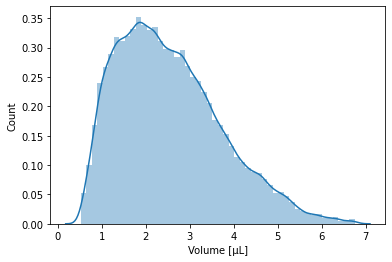

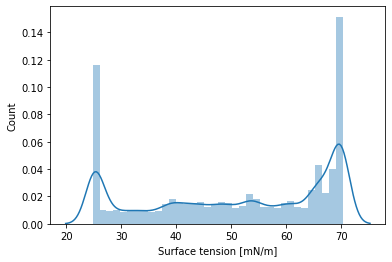

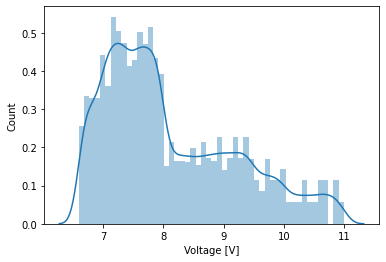

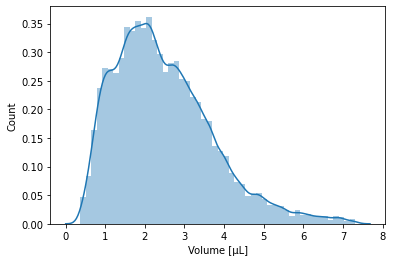

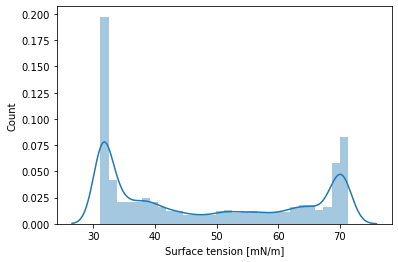

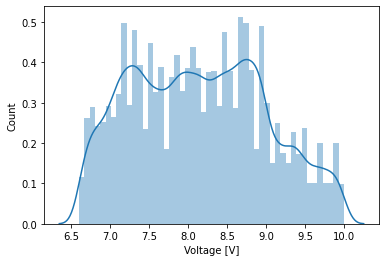

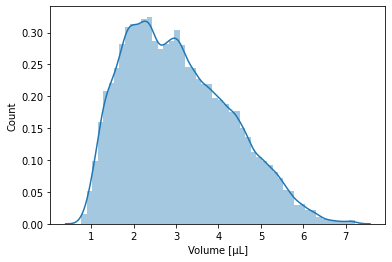

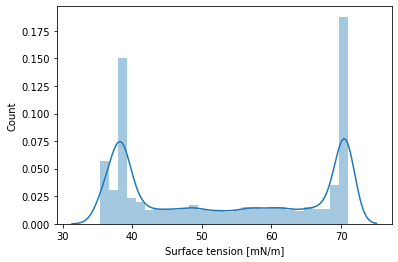

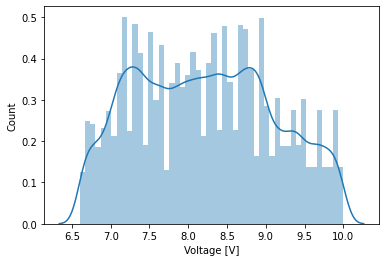

In [9]:
plt.figure()
sns.distplot(dataset_SDS['volume'])
plt.xlabel('Volume [μL]')
plt.ylabel('Count')

plt.figure()
sns.distplot(dataset_SDS['st'])
plt.xlabel('Surface tension [mN/m]')
plt.ylabel('Count')

plt.figure()
sns.distplot(dataset_SDS['volt'])
plt.xlabel('Voltage [V]')
plt.ylabel('Count')
#################################################
plt.figure()
sns.distplot(dataset_TritonX['volume'])
plt.xlabel('Volume [μL]')
plt.ylabel('Count')

plt.figure()
sns.distplot(dataset_TritonX['st'])
plt.xlabel('Surface tension [mN/m]')
plt.ylabel('Count')

plt.figure()
sns.distplot(dataset_TritonX['volt'])
plt.xlabel('Voltage [V]')
plt.ylabel('Count')
##################################################
plt.figure()
sns.distplot(dataset_CTAB['volume'])
plt.xlabel('Volume [μL]')
plt.ylabel('Count')

plt.figure()
sns.distplot(dataset_CTAB['st'])
plt.xlabel('Surface tension [mN/m]')
plt.ylabel('Count')

plt.figure()
sns.distplot(dataset_CTAB['volt'])
plt.xlabel('Voltage [V]')
plt.ylabel('Count')


### Selectively choose data with (almost) constant volume

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

Text(0, 0.5, 'Count')

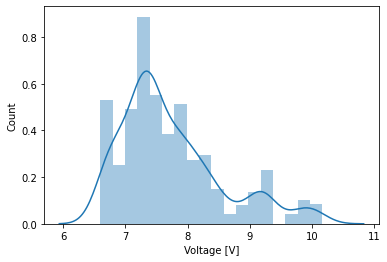

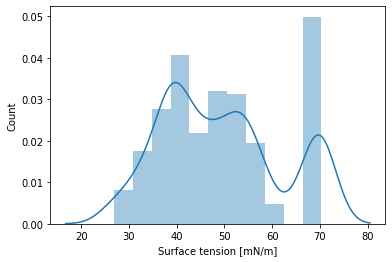

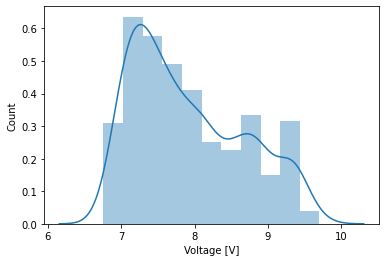

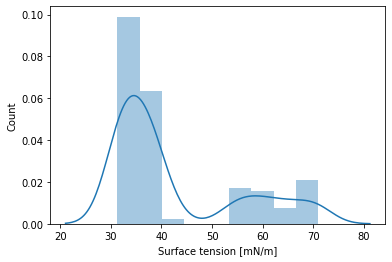

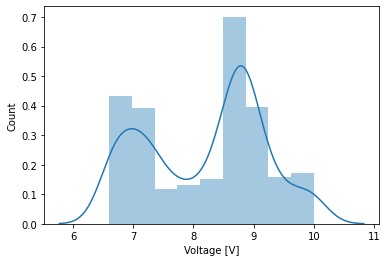

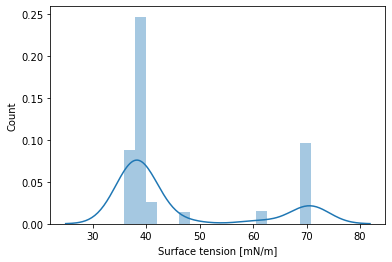

In [90]:
new_input_SDS=[]
new_input_TritonX=[]
new_input_CTAB=[]

vol_min=1.99
vol_max=2.01
for i in range(len(dataset_SDS)):
  if dataset_SDS['volume'].iloc[i] >= vol_min and dataset_SDS['volume'].iloc[i] <= vol_max:
    vol_ct_data=dataset_SDS.iloc[i, :]
    new_input_SDS.append(vol_ct_data)
new_input_SDS=np.asarray(new_input_SDS)
new_input_SDS.shape

plt.figure()
sns.distplot(new_input_SDS[:, 904])
plt.xlabel('Voltage [V]')
plt.ylabel('Count')

plt.figure()
sns.distplot(new_input_SDS[:, 912])
plt.xlabel('Surface tension [mN/m]')
plt.ylabel('Count')

for i in range(len(dataset_TritonX)):
  if dataset_TritonX['volume'].iloc[i] >= vol_min and dataset_TritonX['volume'].iloc[i] <= vol_max:
    vol_ct_data=dataset_TritonX.iloc[i, :]
    new_input_TritonX.append(vol_ct_data)
new_input_TritonX=np.asarray(new_input_TritonX)
new_input_TritonX.shape

plt.figure()
sns.distplot(new_input_TritonX[:, 904])
plt.xlabel('Voltage [V]')
plt.ylabel('Count')

plt.figure()
sns.distplot(new_input_TritonX[:, 912])
plt.xlabel('Surface tension [mN/m]')
plt.ylabel('Count')

for i in range(len(dataset_CTAB)):
  if dataset_CTAB['volume'].iloc[i] >= vol_min and dataset_CTAB['volume'].iloc[i] <= vol_max:
    vol_ct_data=dataset_CTAB.iloc[i, :]
    new_input_CTAB.append(vol_ct_data)
new_input_CTAB=np.asarray(new_input_CTAB)
new_input_CTAB.shape

plt.figure()
sns.distplot(new_input_CTAB[:, 904])
plt.xlabel('Voltage [V]')
plt.ylabel('Count')

plt.figure()
sns.distplot(new_input_CTAB[:, 912])
plt.xlabel('Surface tension [mN/m]')
plt.ylabel('Count')

In [117]:
#Find voltage interseption
a=set(new_input_SDS[:, 904]).intersection(new_input_TritonX[:, 904])
b=set(a).intersection(new_input_CTAB[:, 904])
print(b)

{7.1, 7.34, 6.84, 7.599999999999999, 8.449999999999998, 9.07, 8.929999999999998, 8.55, 9.32, 9.13, 9.22, 7.43, 7.18, 8.38, 6.99}


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will b

Text(0, 0.5, 'Count')

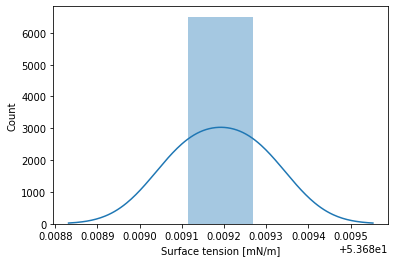

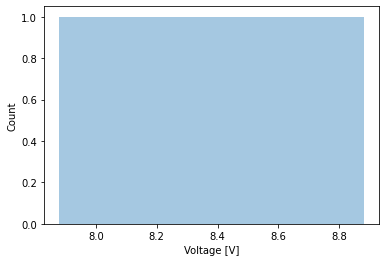

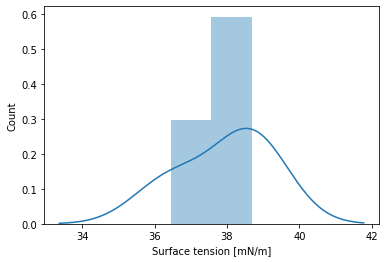

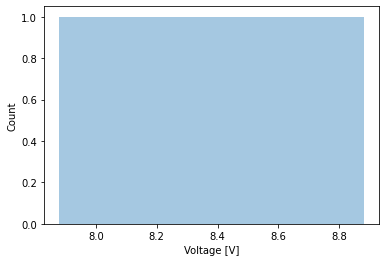

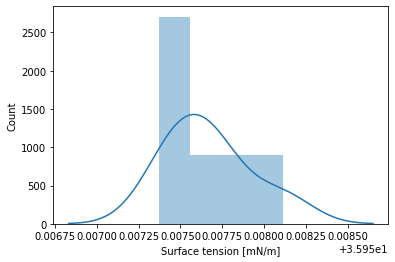

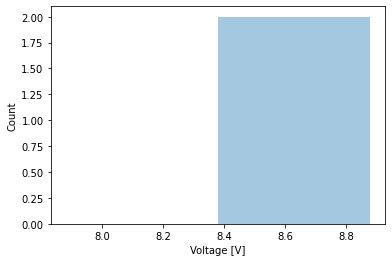

In [118]:
newer_input_SDS=[]
newer_input_TritonX=[]
newer_input_CTAB=[]

Volt_min=8.36
Volt_max=8.4
for i in range(len(new_input_SDS)):
  if new_input_SDS[i, 904] >= Volt_min and new_input_SDS[i, 904] <= Volt_max:
    Ps_ct_data=new_input_SDS[i, :]
    newer_input_SDS.append(Ps_ct_data)
newer_input_SDS=np.asarray(newer_input_SDS)
newer_input_SDS.shape

for i in range(len(new_input_TritonX)):
  if new_input_TritonX[i, 904] >= Volt_min and new_input_TritonX[i, 904] <= Volt_max:
    Ps_ct_data=new_input_TritonX[i, :]
    newer_input_TritonX.append(Ps_ct_data)
newer_input_TritonX=np.asarray(newer_input_TritonX)
newer_input_TritonX.shape

for i in range(len(new_input_CTAB)):
  if new_input_CTAB[i, 904] >= Volt_min and new_input_CTAB[i, 904] <= Volt_max:
    Ps_ct_data=new_input_CTAB[i, :]
    newer_input_CTAB.append(Ps_ct_data)
newer_input_CTAB=np.asarray(newer_input_CTAB)
newer_input_CTAB.shape

##########################################################
plt.figure()
sns.distplot(newer_input_SDS[:, 912])
plt.xlabel('Surface tension [mN/m]')
plt.ylabel('Count')

plt.figure()
sns.distplot(newer_input_SDS[:, 904])
plt.xlabel('Voltage [V]')
plt.ylabel('Count')

#################################################
plt.figure()
sns.distplot(newer_input_TritonX[:, 912])
plt.xlabel('Surface tension [mN/m]')
plt.ylabel('Count')

plt.figure()
sns.distplot(newer_input_TritonX[:, 904])
plt.xlabel('Voltage [V]')
plt.ylabel('Count')

###################################################
plt.figure()
sns.distplot(newer_input_CTAB[:, 912])
plt.xlabel('Surface tension [mN/m]')
plt.ylabel('Count')

plt.figure()
sns.distplot(newer_input_CTAB[:, 904])
plt.xlabel('Voltage [V]')
plt.ylabel('Count')



In [119]:
print(newer_input_SDS[:, 912])
print(newer_input_TritonX[:, 912])
print(newer_input_CTAB[:, 912])

[53.68926917 53.68911549]
[38.63027978 38.69620792 36.4492246 ]
[35.95752192 35.95753981 35.95768439 35.95776995 35.95737243 35.95811158]


In [110]:
final_input_SDS=[]
final_input_TritonX=[]
final_input_CTAB=[]

ST_min=37.8
ST_max=39.53
for i in range(len(newer_input_SDS)):
  if newer_input_SDS[i, 912] >= ST_min and newer_input_SDS[i, 912] <= ST_max:
    ST_ct_data=newer_input_SDS[i, :]
    final_input_SDS.append(ST_ct_data)
final_input_SDS=np.asarray(final_input_SDS)
print('SDS shape:', final_input_SDS.shape)

for i in range(len(newer_input_TritonX)):
  if newer_input_TritonX[i, 912] >= ST_min and newer_input_TritonX[i, 912] <= ST_max:
    ST_ct_data=newer_input_TritonX[i, :]
    final_input_TritonX.append(ST_ct_data)
final_input_TritonX=np.asarray(final_input_TritonX)
print('TritonX shape:', final_input_TritonX.shape)

for i in range(len(newer_input_CTAB)):
  if newer_input_CTAB[i, 912] >= ST_min and newer_input_CTAB[i, 912] <= ST_max:
    ST_ct_data=newer_input_CTAB[i, :]
    final_input_CTAB.append(ST_ct_data)
final_input_CTAB=np.asarray(final_input_CTAB)
print('CTAB shape:', final_input_CTAB.shape)


SDS shape: (5, 913)
TritonX shape: (1, 913)
CTAB shape: (16, 913)


In [ ]:
##########################################################
plt.figure()
sns.distplot(final_input_SDS[:, 912])
plt.xlabel('Surface tension [mN/m]')
plt.ylabel('Count')

plt.figure()
sns.distplot(final_input_SDS[:, 904])
plt.xlabel('Voltage [V]')
plt.ylabel('Count')

plt.figure()
sns.distplot(final_input_SDS[:, 902])
plt.xlabel('Volume [μL]')
plt.ylabel('Count')
#################################################
plt.figure()
sns.distplot(final_input_TritonX[:, 912])
plt.xlabel('Surface tension [mN/m]')
plt.ylabel('Count')

plt.figure()
sns.distplot(final_input_TritonX[:, 904])
plt.xlabel('Voltage [V]')
plt.ylabel('Count')

plt.figure()
sns.distplot(final_input_TritonX[:, 902])
plt.xlabel('Volume [μL]')
plt.ylabel('Count')
###################################################
plt.figure()
sns.distplot(final_input_CTAB[:, 912])
plt.xlabel('Surface tension [mN/m]')
plt.ylabel('Count')

plt.figure()
sns.distplot(final_input_CTAB[:, 904])
plt.xlabel('Voltage [V]')
plt.ylabel('Count')

plt.figure()
sns.distplot(final_input_CTAB[:, 902])
plt.xlabel('Volume [μL]')
plt.ylabel('Count')

##For the same surfactant

###SDS

In [37]:
#Check the potential ST values
print(final_input_SDS[:, 912])
# print(final_input_SDS[1, 912])

[70.26511877 70.26486104 70.26421735]
[70.32212675 70.32247008 70.32201619 70.3211617  70.32126108]
[70.29077183]


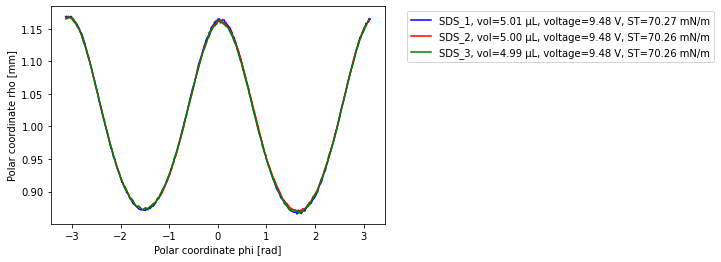

In [42]:
#For the same surfactant [SDS]
SDS_1=0
SDS_2=1
SDS_3=2

plt.figure()
plt.plot(final_input_SDS[SDS_1, 300:600], final_input_SDS[SDS_1, 0:300], '-b', label='SDS_1, vol=%.2f μL, voltage=%.2f V, ST=%.2f mN/m' %(final_input_SDS[SDS_1, 902], final_input_SDS[SDS_1, 904], final_input_SDS[SDS_1, 912]))
plt.plot(final_input_SDS[SDS_2, 300:600], final_input_SDS[SDS_2, 0:300], '-r', label='SDS_2, vol=%.2f μL, voltage=%.2f V, ST=%.2f mN/m' %(final_input_SDS[SDS_2, 902], final_input_SDS[SDS_2, 904], final_input_SDS[SDS_2, 912]))
plt.plot(final_input_SDS[SDS_3, 300:600], final_input_SDS[SDS_3, 0:300], '-g', label='SDS_3, vol=%.2f μL, voltage=%.2f V, ST=%.2f mN/m' %(final_input_SDS[SDS_3, 902], final_input_SDS[SDS_3, 904], final_input_SDS[SDS_3, 912]))
plt.xlabel('Polar coordinate phi [rad]')
plt.ylabel('Polar coordinate rho [mm]')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


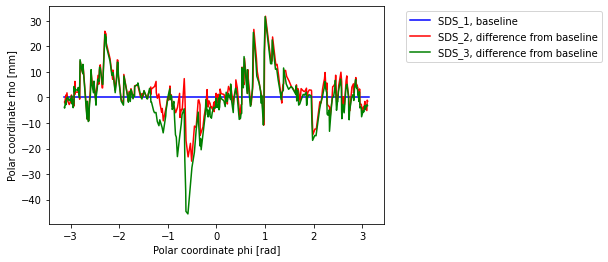

In [72]:
#Difference
SDS_1=0
SDS_2=1
SDS_3=2

# set_baseline_x=final_input_SDS[SDS_1, 300:600]
set_baseline_y=final_input_SDS[SDS_1, 0:300]

plt.figure()
plt.plot(final_input_SDS[SDS_1, 300:600], (final_input_SDS[SDS_1, 0:300]-set_baseline_y)*1000, '-b', label='SDS_1, baseline')
plt.plot(final_input_SDS[SDS_2, 300:600], (final_input_SDS[SDS_2, 0:300]-set_baseline_y)*1000, '-r', label='SDS_2, difference from baseline')
plt.plot(final_input_SDS[SDS_3, 300:600], (final_input_SDS[SDS_3, 0:300]-set_baseline_y)*1000, '-g', label='SDS_3, difference from baseline')
plt.xlabel('Polar coordinate phi [rad]')
plt.ylabel('Polar coordinate rho [mm]')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')



In [39]:
#Convert polar to cartesian coordinates
SDS_x_all=[]
SDS_y_all=[]

for i in range(len(final_input_SDS)):
  [SDS_x, SDS_y]=pol2cart(final_input_SDS[i, 0:300], final_input_SDS[i, 300:600])
  SDS_x_all.append(SDS_x)
  SDS_y_all.append(SDS_y)


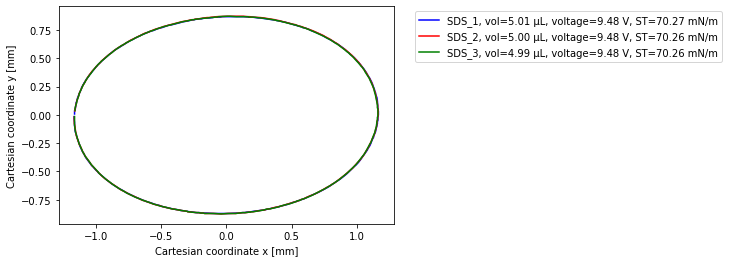

In [43]:
SDS_1=0
SDS_2=1
SDS_3=2
plt.figure()
plt.plot(SDS_x_all[SDS_1], SDS_y_all[SDS_1], '-b', label='SDS_1, vol=%.2f μL, voltage=%.2f V, ST=%.2f mN/m' %(final_input_SDS[SDS_1, 902], final_input_SDS[SDS_1, 904], final_input_SDS[SDS_1, 912]))
plt.plot(SDS_x_all[SDS_2], SDS_y_all[SDS_2], '-r', label='SDS_2, vol=%.2f μL, voltage=%.2f V, ST=%.2f mN/m' %(final_input_SDS[SDS_2, 902], final_input_SDS[SDS_2, 904], final_input_SDS[SDS_2, 912]))
plt.plot(SDS_x_all[SDS_3], SDS_y_all[SDS_3], '-g', label='SDS_3, vol=%.2f μL, voltage=%.2f V, ST=%.2f mN/m' %(final_input_SDS[SDS_3, 902], final_input_SDS[SDS_3, 904], final_input_SDS[SDS_3, 912]))
plt.xlabel('Cartesian coordinate x [mm]')
plt.ylabel('Cartesian coordinate y [mm]')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

###TritonX-100

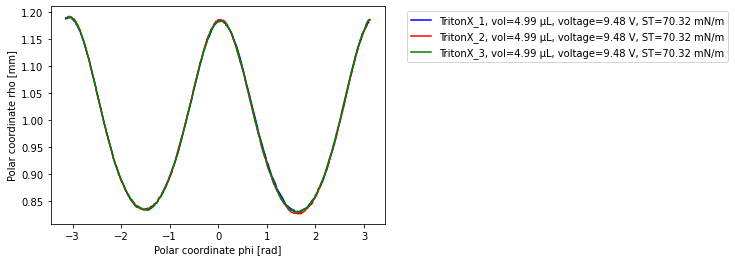

In [44]:
#For the same surfactant [TritonX]
TritonX_1=0
TritonX_2=1
TritonX_3=2

plt.figure()
plt.plot(final_input_TritonX[TritonX_1, 300:600], final_input_TritonX[TritonX_1, 0:300], '-b', label='TritonX_1, vol=%.2f μL, voltage=%.2f V, ST=%.2f mN/m' %(final_input_TritonX[TritonX_1, 902], final_input_TritonX[TritonX_1, 904], final_input_TritonX[TritonX_1, 912]))
plt.plot(final_input_TritonX[TritonX_2, 300:600], final_input_TritonX[TritonX_2, 0:300], '-r', label='TritonX_2, vol=%.2f μL, voltage=%.2f V, ST=%.2f mN/m' %(final_input_TritonX[TritonX_2, 902], final_input_TritonX[TritonX_2, 904], final_input_TritonX[TritonX_2, 912]))
plt.plot(final_input_TritonX[TritonX_3, 300:600], final_input_TritonX[TritonX_3, 0:300], '-g', label='TritonX_3, vol=%.2f μL, voltage=%.2f V, ST=%.2f mN/m' %(final_input_TritonX[TritonX_3, 902], final_input_TritonX[TritonX_3, 904], final_input_TritonX[TritonX_3, 912]))
plt.xlabel('Polar coordinate phi [rad]')
plt.ylabel('Polar coordinate rho [mm]')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


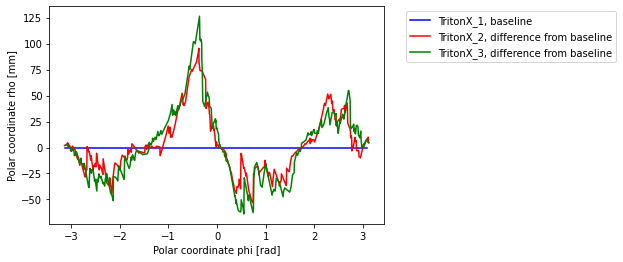

In [71]:
#Difference
TritonX_1=0
TritonX_2=1
TritonX_3=2

# set_baseline_x=final_input_TritonX[TritonX_1, 300:600]
set_baseline_y=final_input_TritonX[TritonX_1, 0:300]

plt.figure()
plt.plot(final_input_TritonX[TritonX_1, 300:600], (final_input_TritonX[TritonX_1, 0:300]-set_baseline_y)*1000, '-b', label='TritonX_1, baseline')
plt.plot(final_input_TritonX[TritonX_2, 300:600], (final_input_TritonX[TritonX_2, 0:300]-set_baseline_y)*1000, '-r', label='TritonX_2, difference from baseline')
plt.plot(final_input_TritonX[TritonX_3, 300:600], (final_input_TritonX[TritonX_3, 0:300]-set_baseline_y)*1000, '-g', label='TritonX_3, difference from baseline')
plt.xlabel('Polar coordinate phi [rad]')
plt.ylabel('Polar coordinate rho [mm]')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')



In [45]:
#Convert polar to cartesian coordinates

TritonX_x_all=[]
TritonX_y_all=[]

for i in range(len(final_input_TritonX)):
  [TritonX_x, TritonX_y]=pol2cart(final_input_TritonX[i, 0:300], final_input_TritonX[i, 300:600])
  TritonX_x_all.append(TritonX_x)
  TritonX_y_all.append(TritonX_y)

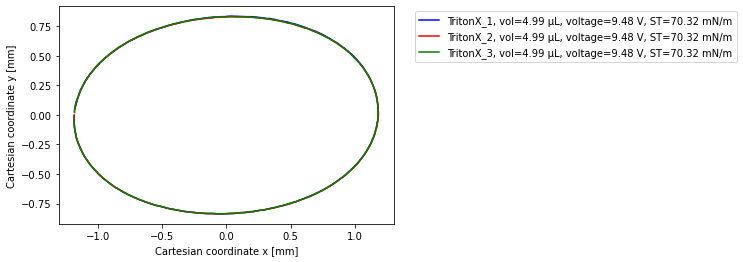

In [46]:
TritonX_1=0
TritonX_2=1
TritonX_3=2
plt.figure()
plt.plot(TritonX_x_all[TritonX_1], TritonX_y_all[TritonX_1], '-b', label='TritonX_1, vol=%.2f μL, voltage=%.2f V, ST=%.2f mN/m' %(final_input_TritonX[TritonX_1, 902], final_input_TritonX[TritonX_1, 904], final_input_TritonX[TritonX_1, 912]))
plt.plot(TritonX_x_all[TritonX_2], TritonX_y_all[TritonX_2], '-r', label='TritonX_2, vol=%.2f μL, voltage=%.2f V, ST=%.2f mN/m' %(final_input_TritonX[TritonX_2, 902], final_input_TritonX[TritonX_2, 904], final_input_TritonX[TritonX_2, 912]))
plt.plot(TritonX_x_all[TritonX_3], TritonX_y_all[TritonX_3], '-g', label='TritonX_3, vol=%.2f μL, voltage=%.2f V, ST=%.2f mN/m' %(final_input_TritonX[TritonX_3, 902], final_input_TritonX[TritonX_3, 904], final_input_TritonX[TritonX_3, 912]))
plt.xlabel('Cartesian coordinate x [mm]')
plt.ylabel('Cartesian coordinate y [mm]')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

###CTAB

In [ ]:
#For the same surfactant [CTAB]
CTAB_1=0
CTAB_2=1
CTAB_3=2

plt.figure()
plt.plot(final_input_CTAB[CTAB_1, 300:600], final_input_CTAB[CTAB_1, 0:300], '-b', label='CTAB_1, vol=%.2f μL, voltage=%.2f V, ST=%.2f mN/m' %(final_input_CTAB[CTAB_1, 902], final_input_CTAB[CTAB_1, 904], final_input_CTAB[CTAB_1, 912]))
plt.plot(final_input_CTAB[CTAB_2, 300:600], final_input_CTAB[CTAB_2, 0:300], '-r', label='CTAB_2, vol=%.2f μL, voltage=%.2f V, ST=%.2f mN/m' %(final_input_CTAB[CTAB_2, 902], final_input_CTAB[CTAB_2, 904], final_input_CTAB[CTAB_2, 912]))
plt.plot(final_input_CTAB[CTAB_3, 300:600], final_input_CTAB[CTAB_3, 0:300], '-g', label='CTAB_3, vol=%.2f μL, voltage=%.2f V, ST=%.2f mN/m' %(final_input_CTAB[CTAB_3, 902], final_input_CTAB[CTAB_3, 904], final_input_CTAB[CTAB_3, 912]))
plt.xlabel('Polar coordinate phi [rad]')
plt.ylabel('Polar coordinate rho [mm]')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


In [ ]:
#Convert polar to cartesian coordinates

CTAB_x_all=[]
CTAB_y_all=[]

for i in range(len(final_input_CTAB)):
  [CTAB_x, CTAB_y]=pol2cart(final_input_CTAB[i, 0:300], final_input_CTAB[i, 300:600])
  CTAB_x_all.append(CTAB_x)
  CTAB_y_all.append(CTAB_y)

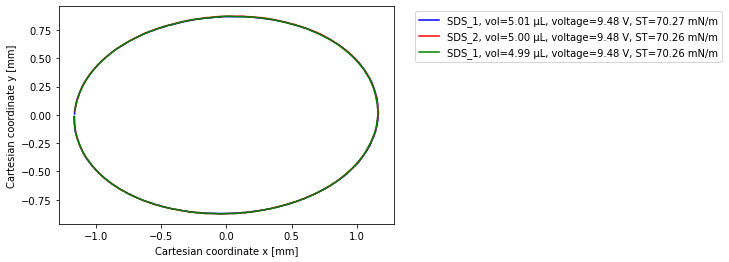

In [ ]:
CTAB_1=0
CTAB_2=1
CTAB_3=2
plt.figure()
plt.plot(CTAB_x_all[CTAB_1], CTAB_y_all[CTAB_1], '-b', label='CTAB_1, vol=%.2f μL, voltage=%.2f V, ST=%.2f mN/m' %(final_input_CTAB[CTAB_1, 902], final_input_CTAB[CTAB_1, 904], final_input_CTAB[CTAB_1, 912]))
plt.plot(CTAB_x_all[CTAB_2], CTAB_y_all[CTAB_2], '-r', label='CTAB_2, vol=%.2f μL, voltage=%.2f V, ST=%.2f mN/m' %(final_input_CTAB[CTAB_2, 902], final_input_CTAB[CTAB_2, 904], final_input_CTAB[CTAB_2, 912]))
plt.plot(CTAB_x_all[CTAB_3], CTAB_y_all[CTAB_3], '-g', label='CTAB_1, vol=%.2f μL, voltage=%.2f V, ST=%.2f mN/m' %(final_input_CTAB[CTAB_3, 902], final_input_CTAB[CTAB_3, 904], final_input_CTAB[CTAB_3, 912]))
plt.xlabel('Cartesian coordinate x [mm]')
plt.ylabel('Cartesian coordinate y [mm]')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

##For different surfactants

In [111]:
print(final_input_SDS[:, 912])
print(final_input_TritonX[:, 912])
print(final_input_CTAB[:, 912])

[37.88301185 37.87252525 37.87084348 37.86421334 37.80427193]
[39.52418689]
[38.26699559 38.26671883 38.2663521  38.26578698 38.26546793 38.26554103
 38.26650058 38.26722    38.80621426 38.08342216 38.08361066 38.08417506
 38.08314298 38.08311336 38.08209788 38.07879168]


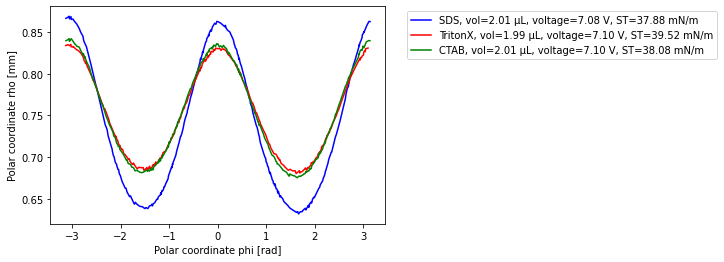

In [112]:
SDS_=0
TritonX_=0
CTAB_=11
plt.figure()
plt.plot(final_input_SDS[SDS_, 300:600], final_input_SDS[SDS_, 0:300], '-b', label='SDS, vol=%.2f μL, voltage=%.2f V, ST=%.2f mN/m' %(final_input_SDS[SDS_, 902], final_input_SDS[SDS_, 904], final_input_SDS[SDS_, 912]))
plt.plot(final_input_TritonX[TritonX_, 300:600], final_input_TritonX[TritonX_, 0:300], '-r', label='TritonX, vol=%.2f μL, voltage=%.2f V, ST=%.2f mN/m' %(final_input_TritonX[TritonX_, 902], final_input_TritonX[TritonX_, 904],  final_input_TritonX[TritonX_, 912]))
plt.plot(final_input_CTAB[CTAB_, 300:600], final_input_CTAB[CTAB_, 0:300], '-g', label='CTAB, vol=%.2f μL, voltage=%.2f V, ST=%.2f mN/m' %(final_input_CTAB[CTAB_, 902], final_input_CTAB[CTAB_, 904],  final_input_CTAB[CTAB_, 912]))
plt.xlabel('Polar coordinate phi [rad]')
plt.ylabel('Polar coordinate rho [mm]')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')



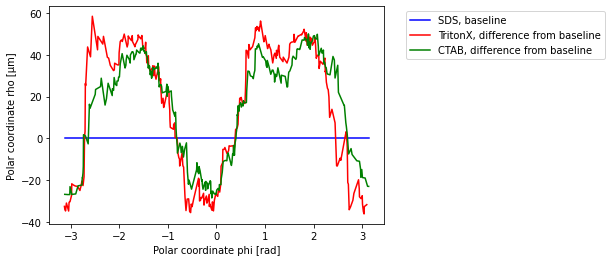

In [114]:
#Difference
SDS_1=0
TritonX_1=0
CTAB_1=11

# set_baseline_x=final_input_TritonX[TritonX_1, 300:600]
set_baseline_y=final_input_SDS[SDS_1, 0:300]

plt.figure()
plt.plot(final_input_SDS[SDS_1, 300:600], (final_input_SDS[SDS_1, 0:300]-set_baseline_y)*1000, '-b', label='SDS, baseline')
plt.plot(final_input_TritonX[TritonX_1, 300:600], (final_input_TritonX[TritonX_1, 0:300]-set_baseline_y)*1000, '-r', label='TritonX, difference from baseline')
plt.plot(final_input_CTAB[CTAB_1, 300:600], (final_input_CTAB[CTAB_1, 0:300]-set_baseline_y)*1000, '-g', label='CTAB, difference from baseline')
plt.xlabel('Polar coordinate phi [rad]')
plt.ylabel('Polar coordinate rho [μm]')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')



In [115]:
[SDS_x, SDS_y]=pol2cart(final_input_SDS[SDS_, 0:300], final_input_SDS[SDS_, 300:600])
[TritonX_x, TritonX_y]=pol2cart(final_input_TritonX[TritonX_, 0:300], final_input_TritonX[TritonX_, 300:600])
[CTAB_x, CTAB_y]=pol2cart(final_input_CTAB[CTAB_, 0:300], final_input_CTAB[CTAB_, 300:600])

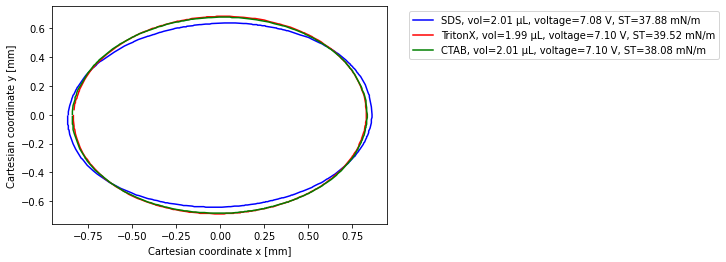

In [116]:
SDS_=0
TritonX_=0
CTAB_=11
plt.figure()
plt.plot(SDS_x, SDS_y, '-b', label='SDS, vol=%.2f μL, voltage=%.2f V, ST=%.2f mN/m' %(final_input_SDS[SDS_, 902], final_input_SDS[SDS_, 904], final_input_SDS[SDS_, 912]))
plt.plot(TritonX_x, TritonX_y, '-r', label='TritonX, vol=%.2f μL, voltage=%.2f V, ST=%.2f mN/m' %(final_input_TritonX[TritonX_, 902], final_input_TritonX[TritonX_, 904],  final_input_TritonX[TritonX_, 912]))
plt.plot(CTAB_x, CTAB_y, '-g', label='CTAB, vol=%.2f μL, voltage=%.2f V, ST=%.2f mN/m' %(final_input_CTAB[CTAB_, 902], final_input_CTAB[CTAB_, 904],  final_input_CTAB[CTAB_, 912]))
plt.xlabel('Cartesian coordinate x [mm]')
plt.ylabel('Cartesian coordinate y [mm]')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

##Compare shape evolution

[53.68926917 53.68911549]
[38.63027978 38.69620792 36.4492246 ]
[35.95752192 35.95753981 35.95768439 35.95776995 35.95737243 35.95811158]


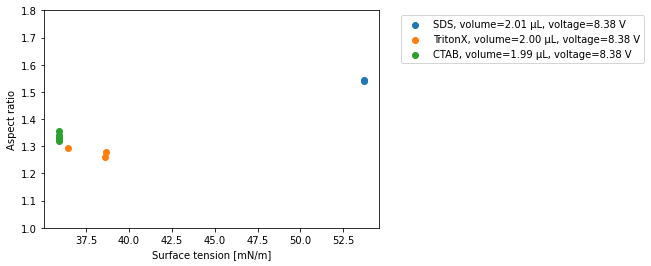

In [120]:
#Parameter new_input has constant volume
#Parameter newer_input has constant voltage
#Parameter final_input has constant ST


print(newer_input_SDS[:, 912])
print(newer_input_TritonX[:, 912])
print(newer_input_CTAB[:, 912])

plt.figure()
plt.scatter(newer_input_SDS[:, 912], newer_input_SDS[:, 911], label='SDS, volume=%.2f μL, voltage=%.2f V' %(np.mean(newer_input_SDS[:, 902]), np.mean(newer_input_SDS[:, 904])))
plt.scatter(newer_input_TritonX[:, 912], newer_input_TritonX[:, 911], label='TritonX, volume=%.2f μL, voltage=%.2f V' %(np.mean(newer_input_TritonX[:, 902]), np.mean(newer_input_TritonX[:, 904])))
plt.scatter(newer_input_CTAB[:, 912], newer_input_CTAB[:, 911], label='CTAB, volume=%.2f μL, voltage=%.2f V' %(np.mean(newer_input_CTAB[:, 902]), np.mean(newer_input_CTAB[:, 904])))
plt.xlabel('Surface tension [mN/m]')
plt.ylabel('Aspect ratio')
plt.ylim(1, 1.8)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')